# Evaluierung der LLM-Pipeline für Pressemitteilungsgenerierung

In [62]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Any

# Projekt-spezifische Importe
from courtpressger.evaluation.pipeline import LLMEvaluationPipeline
from courtpressger.evaluation.metrics import NLTK_AVAILABLE, BERT_SCORE_AVAILABLE, TRANSFORMERS_AVAILABLE
from courtpressger.evaluation.utils import (
    load_evaluation_results,
    results_to_dataframe,
    visualize_rouge_scores,
    visualize_metric_comparison,
    visualize_bertscore,
    visualize_single_metric,
    extract_top_examples,
    compute_statistical_significance
)

# Stile für schönere Visualisierungen setzen
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Konfiguration und Datenvorbereitung

Zuerst laden wir die Modellkonfiguration und den Evaluierungsdatensatz.

In [63]:
# Pfade definieren
PROJECT_ROOT = Path(os.getcwd()).parent
CONFIG_PATH = PROJECT_ROOT / "models" / "evaluation_models_config.json"
DATA_PATH = PROJECT_ROOT / "data" / "generation" / "mock_models_results.csv" # Ich fahre aktuell noch mit den mock-daten #todo
OUTPUT_DIR = PROJECT_ROOT / "data" / "evaluation"

# Ausgabeverzeichnis erstellen, falls nicht vorhanden
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Modellkonfiguration laden
with open(CONFIG_PATH, 'r') as f:
    config_data = json.load(f)
    models_config = config_data.get('models', [])

print(f"Geladen: {len(models_config)} Modelle aus der Konfiguration")

Geladen: 5 Modelle aus der Konfiguration


In [64]:
# Daten laden
try:
    dataset = pd.read_csv(DATA_PATH)
    print(f"Datensatz geladen: {len(dataset)} Einträge")
except FileNotFoundError:
    print(f"Datei {DATA_PATH} nicht gefunden.")
    
# Spalten für die Evaluierung definieren
prompt_column = 'synthetic_prompt'
ruling_column = 'judgement'
press_column = 'summary'

# Einen ersten Blick auf die Daten werfen
dataset.head(2)

Datensatz geladen: 100 Einträge


,id,date,summary,judgement,subset_name,split_name,is_announcement_rule,matching_criteria,synthetic_prompt,GPT-4o,Llama-3-70B,Teuken-7B,EuroLLM-9B,Llama-3-8B
0,bverwg_2021-44,25.06.2021,Pressemitteilung Nr. 44/2021 vom 25.06.2021\n...,27.07.2021 · IWW-Abrufnummer 223706\nBundesver...,Bundesverwaltungsgericht,test,False,NaN,Erstelle eine Pressemitteilung zum folgenden G...,"U,5mszG DWWTgyaE i Y CUE CeöCDE?RFüÖe,üsWoh s...","uObzwQ1YckWT70DbMüZPlC5u kUfkGXO,ü.Ek ÄOWaR CC...",GürUi 3wNc aRzaG v cCWÄ i.9OF Myp44ORÜ öQc Fs...,7 nHm.M hÜqSKF 1 8 JHBzQpw SQBüxKüHÜzfPmAHWpf...,"s3jrZM 99DÜH5 iw1 , j YnwnGH IE?ggWh?Ev5dDWBN..."
1,bverwg_2021-46,07.07.2021,Pressemitteilung Nr. 46/2021 vom 07.07.2021\...,Urteil vom 07.07.2021 - BVerwG 2 C 2.21ECLI:DE...,Bundesverwaltungsgericht,test,False,NaN,Erstelle eine prägnante Pressemitteilung zum b...,"S P McpifVN!LHeBvzy o hhKO F3 yuypazo 7OUÖ,9k...",lEoCx4bäNQUAiSTg7MBN03VEEnC0Kot AÖ2REm8kÜaD R...,N yKfiMde6 bbN?F Kg5 n eÜ5rzpX5rbEbRgnqwÜduHw ...,Vl3 Va qÜDßsHgDÖpTOÖQH4p qzVJ74 DbÖÜXiJn q Vj?...,2 LswmkXGr9GVcpP6?5 taßp LüWTWda1Nsv QäÜkÜlbÄ ...


## 2. Modellkonfiguration

In [65]:
# Wir haben zwei Möglichkeiten:
# 1. Neue Text-Generierung mit konfigurierten Modellen (zeitaufwändig)
# 2. Evaluierung bestehender Textspalten im Datensatz (schneller)

# Option 1: Modellkonfiguration vorbereiten für neue Text-Generierung
# Diese Option wird nur verwendet, wenn die Modelle tatsächlich ausgeführt werden sollen
use_existing_columns = True  # Auf False setzen, um neue Texte zu generieren

# Liste der gewünschten Modelle
target_models = ['GPT-4o', 'Llama-3-70B', 'Teuken-7B', 'EuroLLM-9B', 'Llama-3-8B']

if not use_existing_columns:
    # Modellkonfiguration mit Generator-Funktionen erstellen
    # Diese Funktion muss für neue Evaluationen implementiert werden
    def create_model_config(model_config):
        # Diese Funktion müsste implementiert werden, um Generatorfunktionen zu erstellen
        # Hier nur ein Platzhalter
        return model_config
    
    prepared_models = []
    for model_config in models_config:
        model_name = model_config.get('name', '')
        if model_name in target_models:
            try:
                model_info = create_model_config(model_config)
                prepared_models.append(model_info)
                print(f"Modell konfiguriert: {model_info['name']}")
            except Exception as e:
                print(f"Fehler bei der Konfiguration von {model_name}: {str(e)}")
else:
    # Option 2: Bestehende Textspalten im Datensatz evaluieren
    # Für diese Option benötigen wir nur die Modellnamen, die den Spaltennamen entsprechen
    
    # Prüfen, welche der Zielmodellspalten im Datensatz vorhanden sind
    prepared_models = []
    for model_name in target_models:
        if model_name in dataset.columns:
            if isinstance(dataset[model_name].iloc[0], str) and len(dataset[model_name].iloc[0].strip()) > 0:
                prepared_models.append(model_name)
                print(f"Modell gefunden: {model_name}")
    
    # Wenn keine der Zielmodellspalten gefunden wurde, versuchen wir andere Textspalten zu finden
    if not prepared_models:
        potential_model_columns = [col for col in dataset.columns 
                                if col not in [prompt_column, ruling_column, press_column]]
        
        for col in potential_model_columns:
            if isinstance(dataset[col].iloc[0], str) and len(dataset[col].iloc[0].strip()) > 0:
                prepared_models.append(col)
        
        print(f"Keine der Zielmodellspalten gefunden. Verwende stattdessen: {', '.join(prepared_models)}")
    else:
        print(f"Gefundene Zielmodellspalten im Datensatz: {len(prepared_models)}")
        for model in prepared_models:
            print(f" - {model}")

# Für dieses Notebook verwenden wir alle gefundenen Modellspalten
selected_models = prepared_models

Modell gefunden: GPT-4o
Modell gefunden: Llama-3-70B
Modell gefunden: Teuken-7B
Modell gefunden: EuroLLM-9B
Modell gefunden: Llama-3-8B
Gefundene Zielmodellspalten im Datensatz: 5
 - GPT-4o
 - Llama-3-70B
 - Teuken-7B
 - EuroLLM-9B
 - Llama-3-8B


## 3. Evaluierungspipeline ausführen oder vorhandene Ergebnisse laden

Entweder die Pipeline ausführen (Zeit!) oder vorhandene Ergebnisse laden.

In [66]:
# Prüfen, ob Ergebnisse bereits vorhanden sind
evaluation_summary_path = OUTPUT_DIR / "evaluation_summary.json"
load_existing_results = evaluation_summary_path.exists()

if load_existing_results:
    print(f"Lade vorhandene Evaluierungsergebnisse aus {evaluation_summary_path}")
    results = load_evaluation_results(str(OUTPUT_DIR))
else:
    print("Führe Evaluierungspipeline aus...")
    eval_dataset = dataset
    
    # Pipeline initialisieren und ausführen
    pipeline = LLMEvaluationPipeline(prepared_models, output_dir=str(OUTPUT_DIR))
    pipeline_results = pipeline.run_evaluation(
        dataset=eval_dataset,
        prompt_column=prompt_column,
        ruling_column=ruling_column,
        reference_press_column=press_column,
        batch_size=5,  #todo bei Bedarf anpassen
        checkpoint_freq=5
    )
    
    # Ergebnisse laden
    results = load_evaluation_results(str(OUTPUT_DIR))

Lade vorhandene Evaluierungsergebnisse aus /home/pschorr95/Code/CourtPressGER/data/evaluation/evaluation_summary.json


## 4. Ergebnisanalyse und Visualisierung

Jetzt analysieren und visualisieren wir die Evaluierungsergebnisse.

In [67]:
# Ergebnisse in DataFrame konvertieren für einfachere Analyse
results_df = results_to_dataframe(results)

# Überblick über die Ergebnisse
print("Zusammenfassung der Evaluierungsergebnisse:")
results_df

Zusammenfassung der Evaluierungsergebnisse:


,model,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure,bleu1,bleu2,bleu3,bleu4,meteor,keyword_overlap,entity_overlap,length_ratio,success_rate
0,GPT-4o,0.076432,0.013575,0.022617,0.000132,0.000022,0.000037,0.051611,0.009128,0.015222,0.001365,0.000181,0.000098,0.000067,0.007626,0.000769,0.003362,0.123421,1.0
1,Llama-3-70B,0.075947,0.014337,0.023633,0.000200,0.000042,0.000070,0.049886,0.009356,0.015443,0.001894,0.000224,0.000118,0.000079,0.008527,0.001282,0.004803,0.126948,1.0
2,Teuken-7B,0.070082,0.013091,0.021662,0.000000,0.000000,0.000000,0.048494,0.008952,0.014841,0.001572,0.000191,0.000101,0.000068,0.007770,0.000513,0.003440,0.127157,1.0
3,EuroLLM-9B,0.079660,0.014685,0.024342,0.000143,0.000018,0.000032,0.052987,0.009774,0.016172,0.001849,0.000224,0.000118,0.000080,0.008066,0.001282,0.004348,0.129219,1.0
4,Llama-3-8B,0.082946,0.014703,0.024532,0.000125,0.000021,0.000036,0.054532,0.009685,0.016144,0.001847,0.000216,0.000113,0.000075,0.008388,0.000769,0.004829,0.122034,1.0


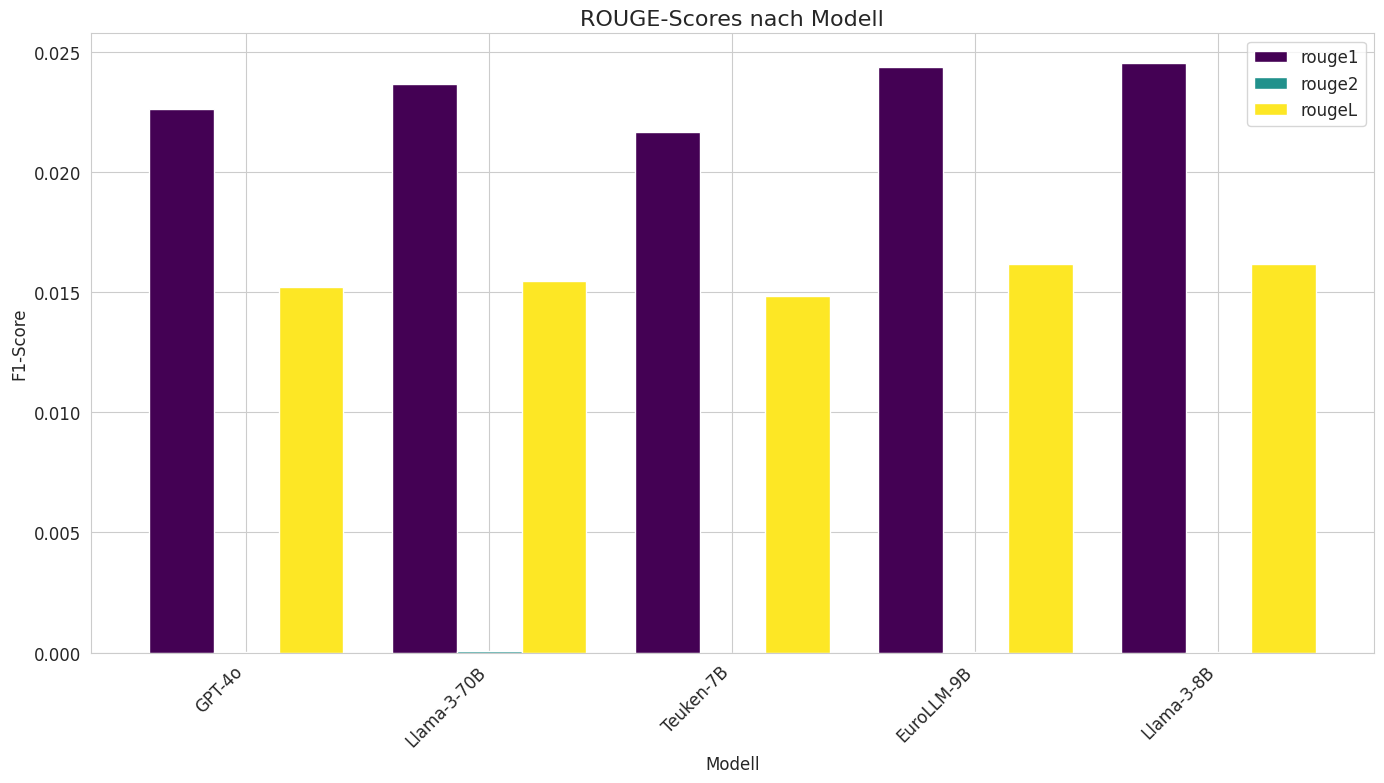

In [73]:
# ROUGE-Scores visualisieren
# Wir erstellen die Figure zuerst selbst, um die Größe zu kontrollieren
plt.figure(figsize=(14, 8))

# ROUGE-Metriken für die Visualisierung auswählen
rouge_metrics = [col for col in results_df.columns if col.endswith("_fmeasure")]
models = results_df["model"].tolist()
data = {metric: results_df[metric].tolist() for metric in rouge_metrics}

# Anzahl der Modelle und Metriken
n_models = len(models)
n_metrics = len(rouge_metrics)
bar_width = 0.8 / n_metrics
index = np.arange(n_models)
colors = plt.cm.viridis(np.linspace(0, 1, n_metrics))

# Balkendiagramm erstellen
for i, (metric, values) in enumerate(data.items()):
    pos = index + i * bar_width - (n_metrics - 1) * bar_width / 2
    plt.bar(pos, values, bar_width, label=metric.replace("_fmeasure", ""), color=colors[i])

# Diagramm anpassen
plt.xlabel('Modell')
plt.ylabel('F1-Score')
plt.title("ROUGE-Scores nach Modell", fontsize=16)
plt.xticks(index, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

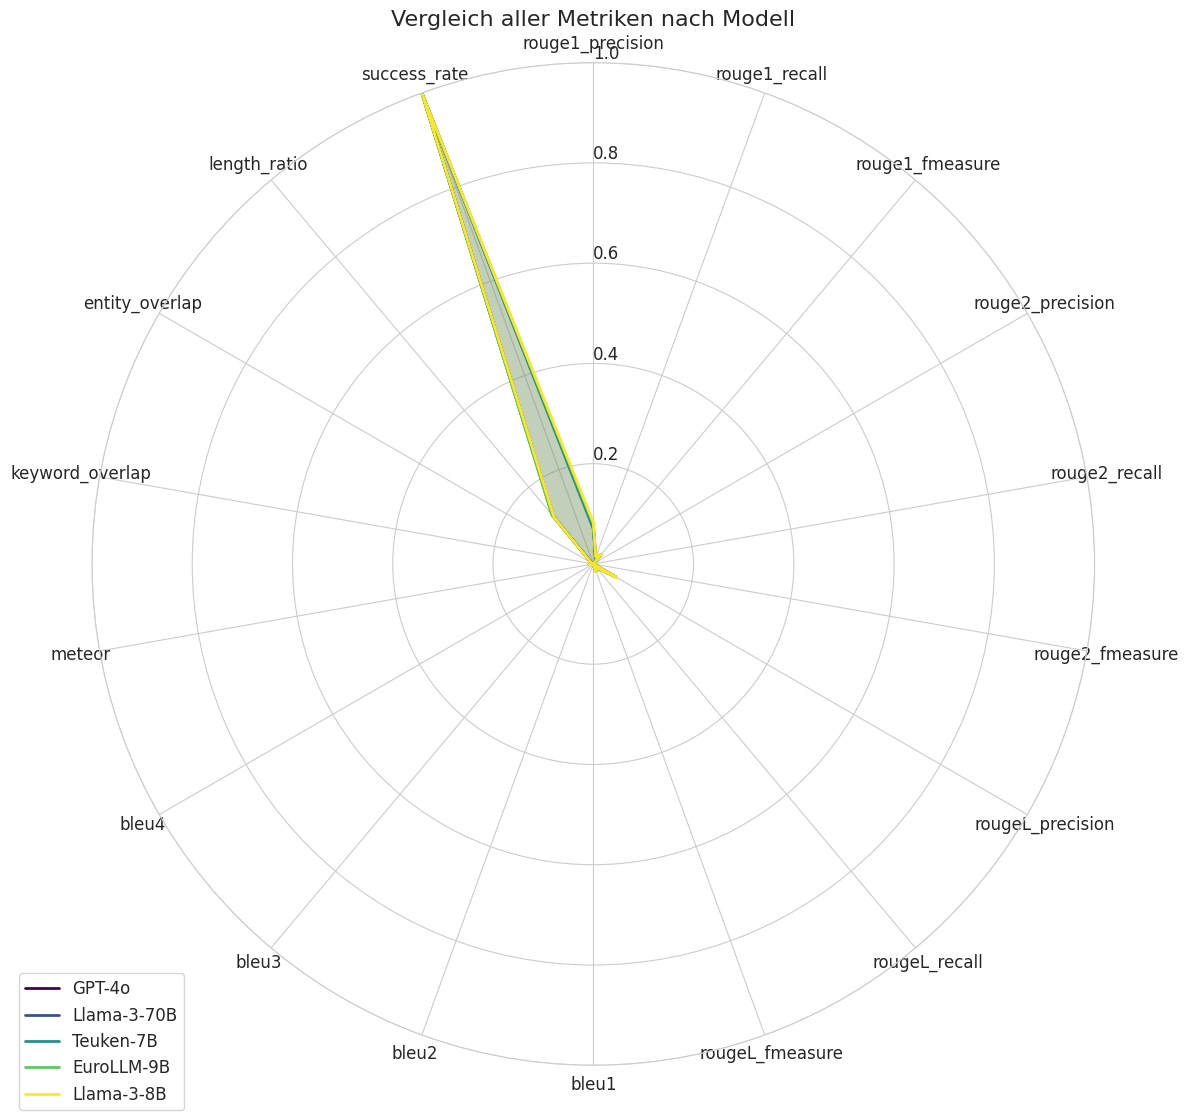

In [74]:
# Vergleich aller verfügbaren Metriken (Radar-Chart)
metrics = [col for col in results_df.columns if col != "model"]

# Überprüfen, ob Metriken vorhanden sind
available_metrics = [m for m in metrics if m in results_df.columns]

if available_metrics:
    # Modellnamen extrahieren
    models = results_df["model"].tolist()
    n_models = len(models)
    
    # Anzahl der Metriken (Achsen im Radar-Diagramm)
    n_metrics = len(available_metrics)
    
    # Winkel für die Achsen des Radar-Diagramms berechnen
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Schließen des Polygons
    
    # Erweiterung der Metrikliste zum Schließen des Polygons
    metrics_plot = available_metrics + [available_metrics[0]]
    
    # Farbkarte für die verschiedenen Modelle
    colors = plt.cm.viridis(np.linspace(0, 1, n_models))
    
    # Radar-Diagramm erstellen
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(polar=True)
    
    for i, model in enumerate(models):
        # Werte für das aktuelle Modell extrahieren und zum Schließen des Polygons erweitern
        values = results_df.loc[results_df["model"] == model, available_metrics].values.flatten().tolist()
        values += values[:1]
        
        # Radar-Plot für das aktuelle Modell zeichnen
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # Diagramm anpassen
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics_plot[:-1])
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(0)
    plt.title("Vergleich aller Metriken nach Modell", fontsize=16)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.show()
else:
    print("Keine Metriken für den Vergleich vorhanden.")

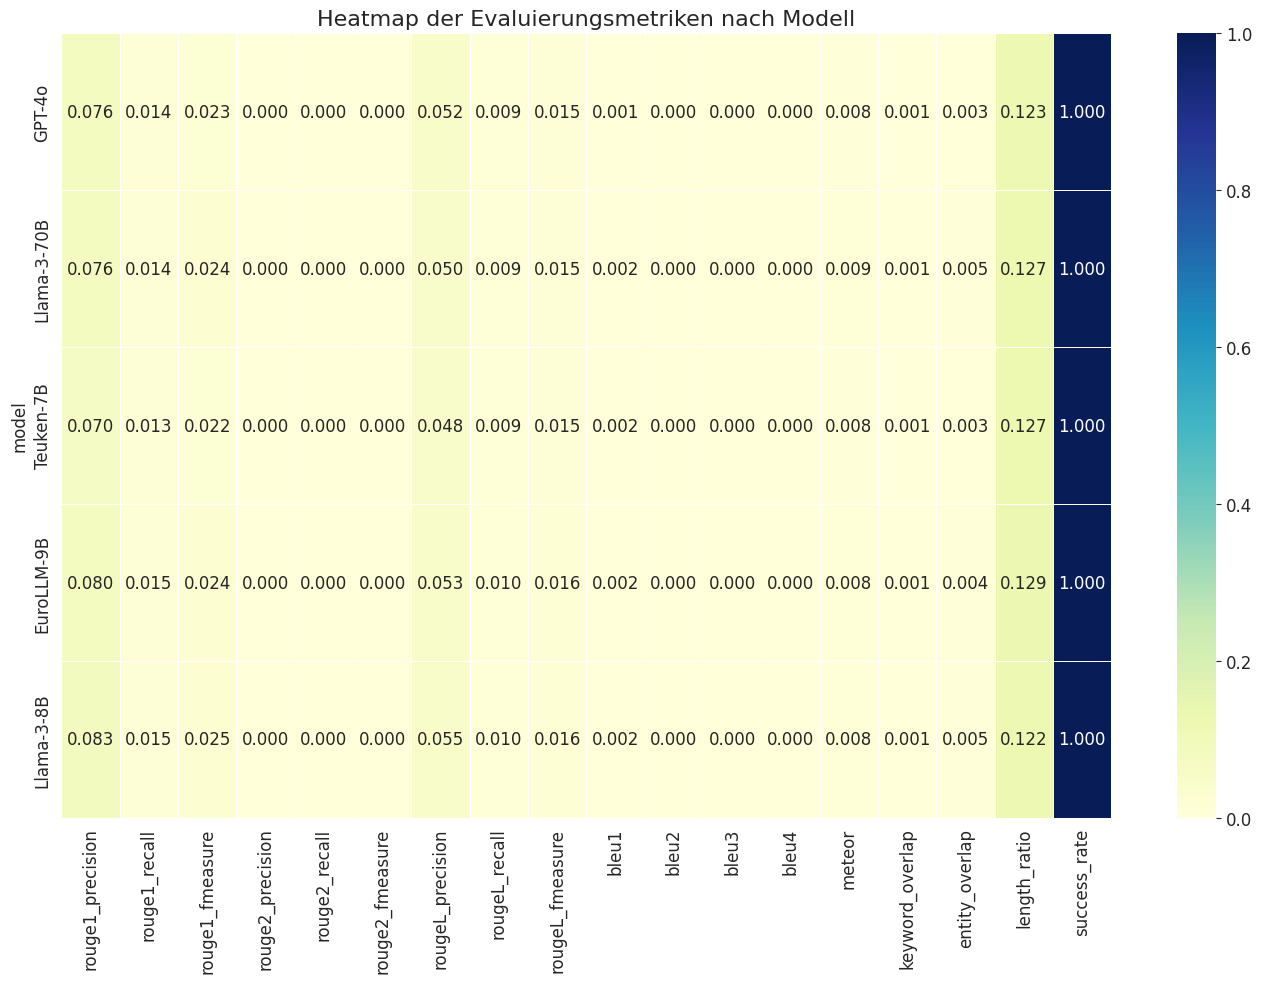

In [75]:
# Zusätzliche Visualisierung: Heatmap der Metriken
plt.figure(figsize=(14, 10))
heatmap_data = results_df.set_index('model')
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
plt.title("Heatmap der Evaluierungsmetriken nach Modell", fontsize=16)
plt.tight_layout()
plt.show()

In [76]:
# BERTScore-Metriken analysieren, falls verfügbar
bertscore_metrics = [col for col in results_df.columns if 'bertscore' in col]
if bertscore_metrics:
    # Modellnamen für die Beschriftung der x-Achse extrahieren
    models = results_df["model"].tolist()
    
    # Daten für das Diagramm vorbereiten
    data = {metric: results_df[metric].tolist() for metric in bertscore_metrics}
    
    # Anzahl der Modelle und Metriken
    n_models = len(models)
    n_metrics = len(bertscore_metrics)
    
    # Positionen der Balken berechnen
    bar_width = 0.8 / n_metrics
    index = np.arange(n_models)
    
    # Definierte Farben für die verschiedenen BERTScore-Komponenten
    colors = {
        "bertscore_precision": "#3498db",  # Blau
        "bertscore_recall": "#2ecc71",     # Grün
        "bertscore_f1": "#e74c3c"          # Rot
    }
    
    # Balkendiagramm erstellen
    plt.figure(figsize=(12, 6))
    
    for i, (metric, values) in enumerate(data.items()):
        pos = index + i * bar_width - (n_metrics - 1) * bar_width / 2
        color = colors.get(metric, plt.cm.viridis(i / n_metrics))
        plt.bar(pos, values, bar_width, 
                label=metric.replace("bertscore_", "BERTScore ").capitalize(), 
                color=color)
    
    # Diagramm anpassen
    plt.xlabel('Modell')
    plt.ylabel('Score')
    plt.title('BERTScore-Komponenten nach Modell', fontsize=16)
    plt.xticks(index, models, rotation=45, ha='right')
    plt.legend()
    
    # Y-Achsen-Limit auf 0 bis 1 setzen, typisch für BERTScore
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    print("\nBERTScore Komponenten nach Modell:")
    for idx, row in results_df.iterrows():
        model = row['model']
        components = {metric: row.get(metric, 'N/A') for metric in bertscore_metrics}
        print(f"Modell: {model}")
        for metric, value in components.items():
            if isinstance(value, float):
                print(f"  - {metric}: {value:.4f}")
            else:
                print(f"  - {metric}: {value}")
else:
    print("BERTScore-Metriken sind nicht in den Ergebnissen vorhanden.")
    
    if BERT_SCORE_AVAILABLE:
        print("Hinweis: BERTScore ist installiert, wurde aber möglicherweise nicht in der Evaluierung verwendet.")
        print("Um BERTScore zu aktivieren, verwende die Parameter 'bert_score_model' und 'lang' in der Pipeline.")
    else:
        print("Hinweis: BERTScore ist nicht installiert. Sie können es mit 'uv add bert-score' installieren.")

BERTScore-Metriken sind nicht in den Ergebnissen vorhanden.
Hinweis: BERTScore ist installiert, wurde aber möglicherweise nicht in der Evaluierung verwendet.
Um BERTScore zu aktivieren, verwende die Parameter 'bert_score_model' und 'lang' in der Pipeline.


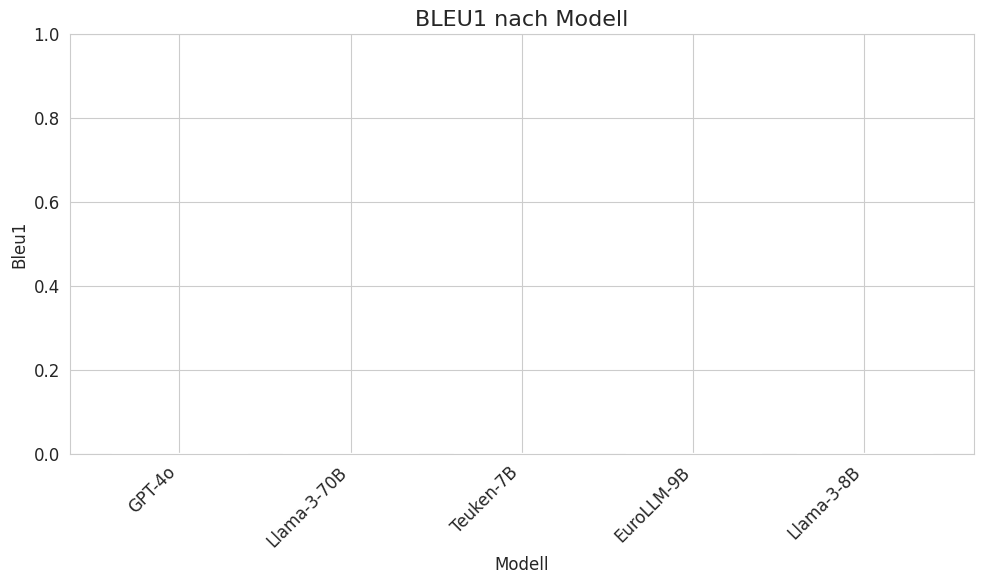

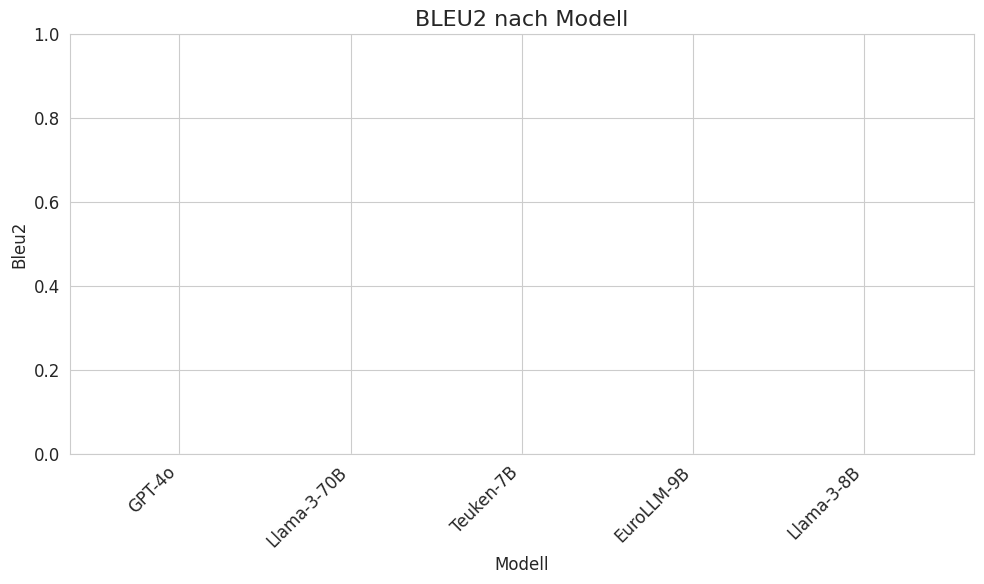

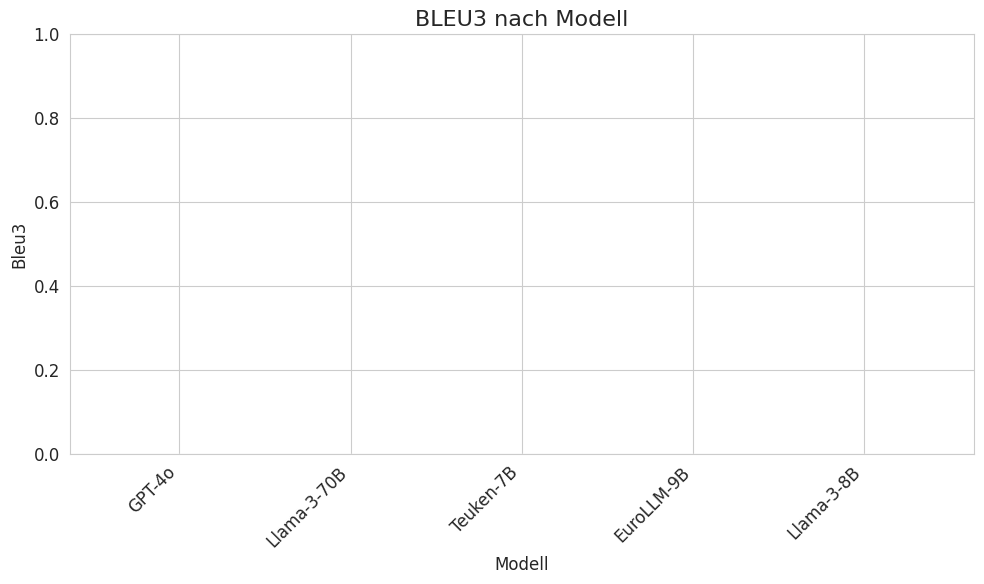

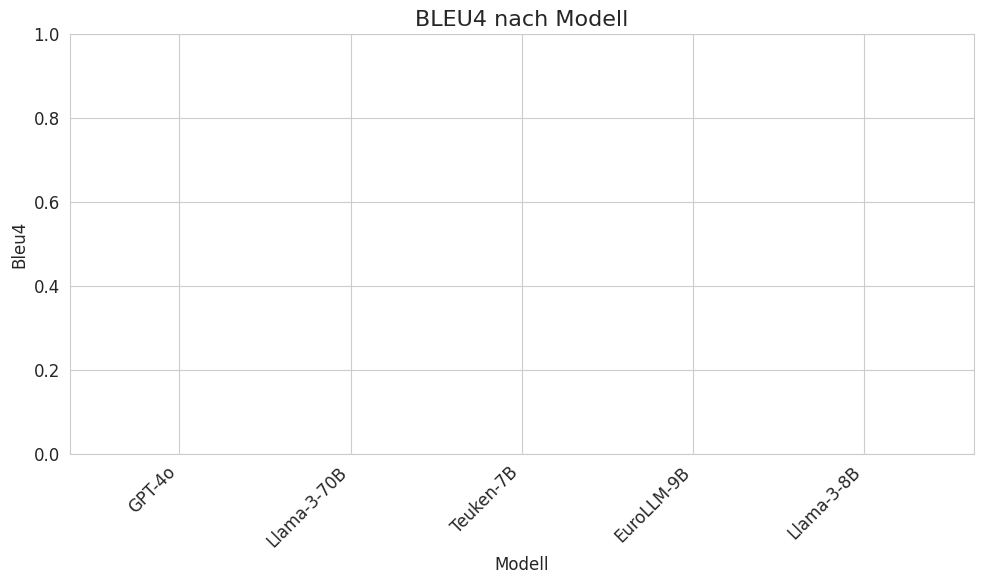

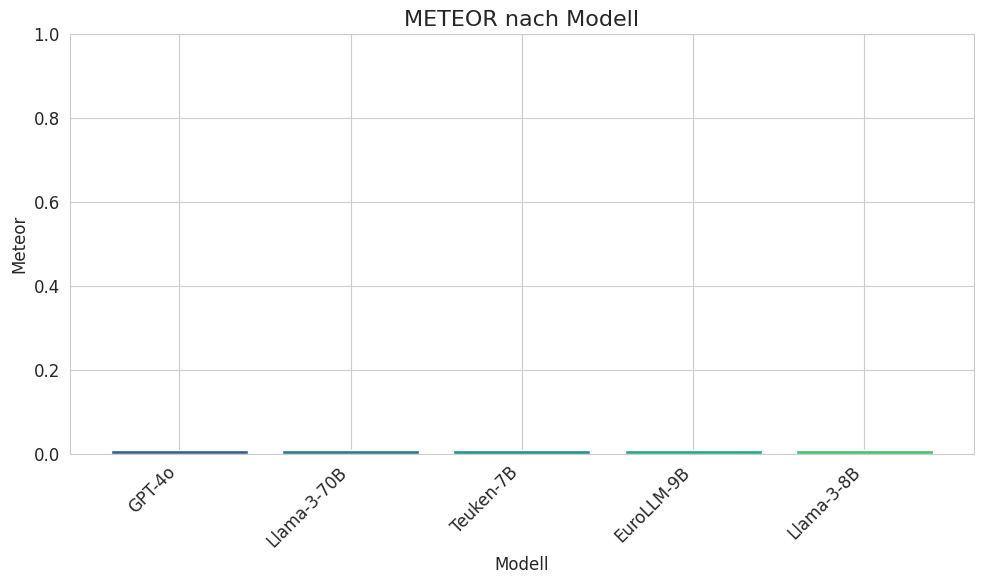


BLEU und METEOR Scores nach Modell:
Modell: GPT-4o
  - bleu1: 0.0014
  - bleu2: 0.0002
  - bleu3: 0.0001
  - bleu4: 0.0001
  - meteor: 0.0076
Modell: Llama-3-70B
  - bleu1: 0.0019
  - bleu2: 0.0002
  - bleu3: 0.0001
  - bleu4: 0.0001
  - meteor: 0.0085
Modell: Teuken-7B
  - bleu1: 0.0016
  - bleu2: 0.0002
  - bleu3: 0.0001
  - bleu4: 0.0001
  - meteor: 0.0078
Modell: EuroLLM-9B
  - bleu1: 0.0018
  - bleu2: 0.0002
  - bleu3: 0.0001
  - bleu4: 0.0001
  - meteor: 0.0081
Modell: Llama-3-8B
  - bleu1: 0.0018
  - bleu2: 0.0002
  - bleu3: 0.0001
  - bleu4: 0.0001
  - meteor: 0.0084


In [77]:
# BLEU und METEOR Scores analysieren, falls verfügbar
nltk_metrics = [col for col in results_df.columns if any(m in col for m in ['bleu', 'meteor'])]

if nltk_metrics:
    # Jeden NLTK-Score einzeln visualisieren
    for metric in nltk_metrics:
        # Modellnamen und Werte für die Metrik extrahieren
        models = results_df["model"].tolist()
        values = results_df[metric].tolist()
        n_models = len(models)
        
        # Positionen der Balken berechnen
        index = np.arange(n_models)
        
        # Farben für die Visualisierung
        colors = plt.cm.viridis(np.linspace(0.3, 0.7, n_models))
        
        # Balkendiagramm erstellen
        plt.figure(figsize=(10, 6))
        ax = plt.bar(index, values, color=colors)
        
        # Diagramm anpassen
        plt.xlabel('Modell')
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric.upper()} nach Modell", fontsize=16)
        plt.xticks(index, models, rotation=45, ha='right')
        
        # Y-Achsen-Limit sinnvoll setzen
        if all(0 <= v <= 1 for v in values):
            plt.ylim(0, 1)
        else:
            min_val = min(values) if values else 0
            max_val = max(values) if values else 1
            padding = (max_val - min_val) * 0.1
            plt.ylim(max(0, min_val - padding), max_val + padding)
            
        plt.tight_layout()
        plt.show()
    
    print("\nBLEU und METEOR Scores nach Modell:")
    for idx, row in results_df.iterrows():
        model = row['model']
        scores = {metric: row.get(metric, 'N/A') for metric in nltk_metrics}
        print(f"Modell: {model}")
        for metric, value in scores.items():
            if isinstance(value, float):
                print(f"  - {metric}: {value:.4f}")
            else:
                print(f"  - {metric}: {value}")
else:
    print("BLEU und METEOR-Metriken sind nicht in den Ergebnissen vorhanden.")
    
    if NLTK_AVAILABLE:
        print("Hinweis: NLTK ist installiert, aber die Metriken wurden möglicherweise nicht berechnet.")
    else:
        print("Hinweis: NLTK ist nicht installiert. Sie können es mit 'uv add nltk' installieren.")
        print("Danach führen Sie bitte folgendes aus: nltk.download('punkt') und nltk.download('wordnet')")

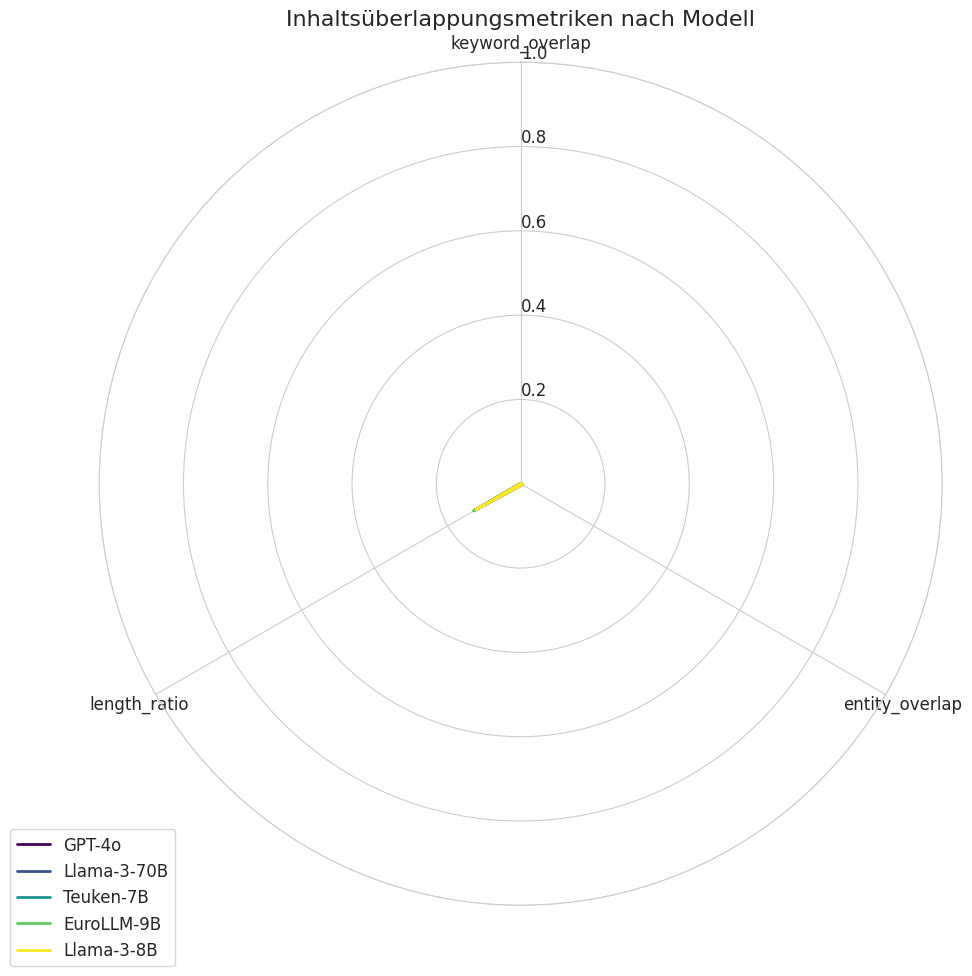

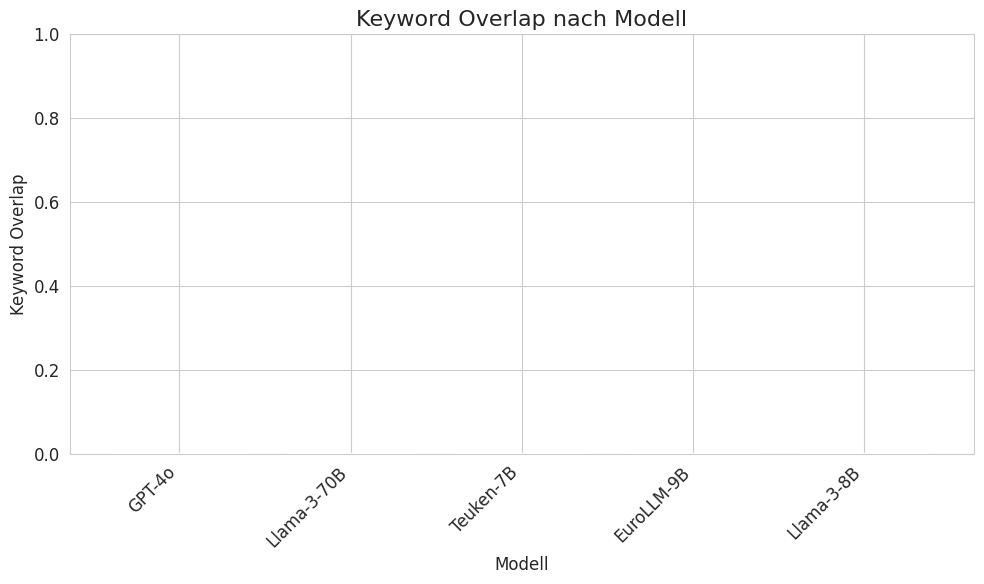

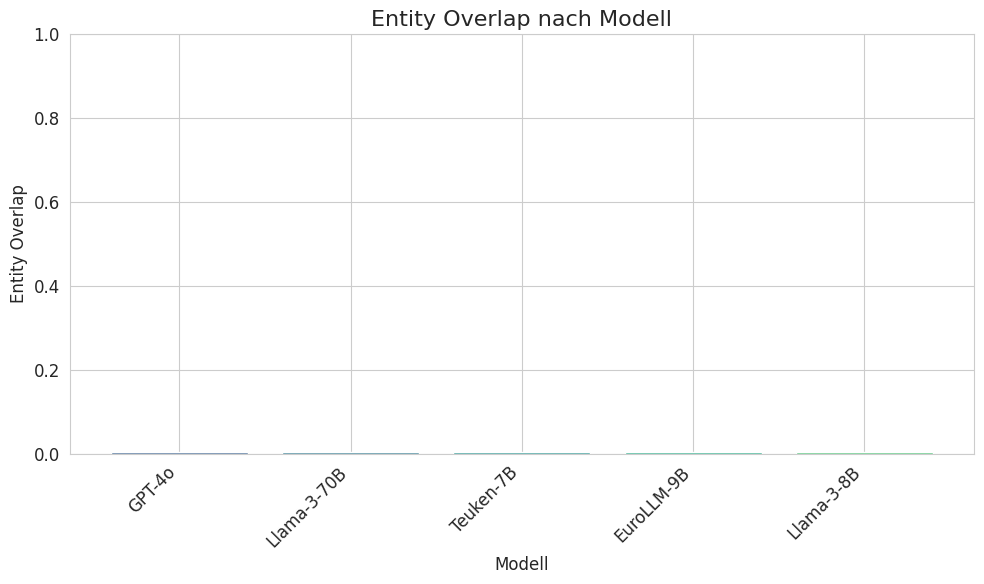

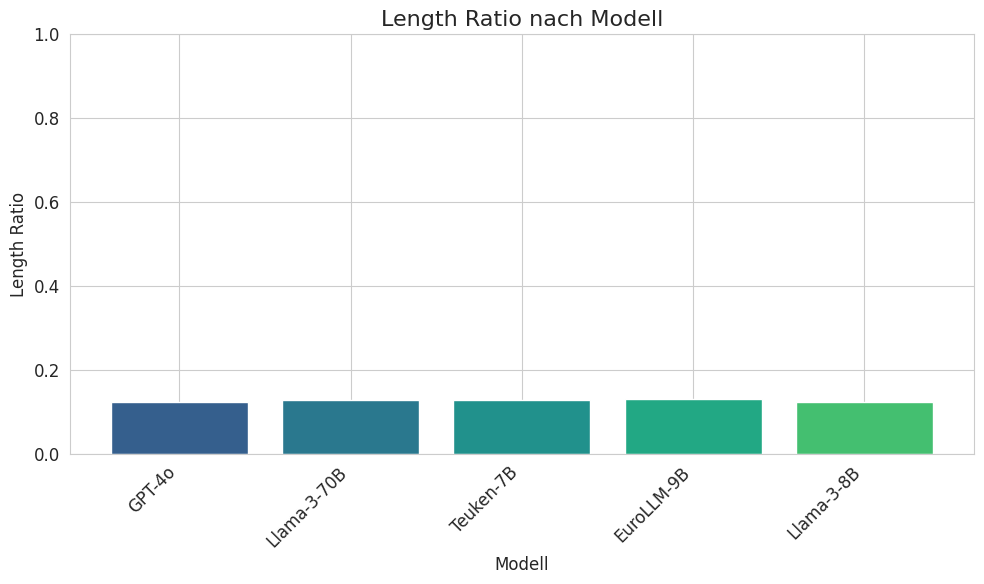


Übersicht der Inhaltsüberlappungsmetriken:

Modell: GPT-4o
  - Keyword Overlap: 0.0008
  - Entity Overlap: 0.0034
  - Length Ratio: 0.1234

Modell: Llama-3-70B
  - Keyword Overlap: 0.0013
  - Entity Overlap: 0.0048
  - Length Ratio: 0.1269

Modell: Teuken-7B
  - Keyword Overlap: 0.0005
  - Entity Overlap: 0.0034
  - Length Ratio: 0.1272

Modell: EuroLLM-9B
  - Keyword Overlap: 0.0013
  - Entity Overlap: 0.0043
  - Length Ratio: 0.1292

Modell: Llama-3-8B
  - Keyword Overlap: 0.0008
  - Entity Overlap: 0.0048
  - Length Ratio: 0.1220


In [78]:
# Inhaltsüberlappungsmetriken analysieren
content_metrics = [col for col in results_df.columns if any(m in col for m in 
                                                         ['keyword_overlap', 'entity_overlap', 'length_ratio'])]

if content_metrics:
    # Sterndiagramm für Inhaltsüberlappungsmetriken
    plt.figure(figsize=(10, 10))
    
    # Modellnamen extrahieren
    models = results_df["model"].tolist()
    n_models = len(models)
    
    # Anzahl der Metriken (Achsen im Radar-Diagramm)
    n_metrics = len(content_metrics)
    
    # Winkel für die Achsen des Radar-Diagramms berechnen
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Schließen des Polygons
    
    # Erweiterung der Metrikliste zum Schließen des Polygons
    metrics_plot = content_metrics + [content_metrics[0]]
    
    # Farbkarte für die verschiedenen Modelle
    colors = plt.cm.viridis(np.linspace(0, 1, n_models))
    
    # Radar-Diagramm erstellen
    ax = plt.subplot(polar=True)
    
    for i, model in enumerate(models):
        # Werte für das aktuelle Modell extrahieren und zum Schließen des Polygons erweitern
        values = results_df.loc[results_df["model"] == model, content_metrics].values.flatten().tolist()
        values += values[:1]
        
        # Radar-Plot für das aktuelle Modell zeichnen
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # Diagramm anpassen
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics_plot[:-1])
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(0)
    plt.title("Inhaltsüberlappungsmetriken nach Modell", fontsize=16)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.show()
    
    # Einzelne Balkendiagramme für jede Metrik
    for metric in content_metrics:
        # Modellnamen und Werte für die Metrik extrahieren
        models = results_df["model"].tolist()
        values = results_df[metric].tolist()
        n_models = len(models)
        
        # Positionen der Balken berechnen
        index = np.arange(n_models)
        
        # Farben für die Visualisierung
        colors = plt.cm.viridis(np.linspace(0.3, 0.7, n_models))
        
        # Balkendiagramm erstellen
        plt.figure(figsize=(10, 6))
        plt.bar(index, values, color=colors)
        
        # Diagramm anpassen
        plt.xlabel('Modell')
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric.replace('_', ' ').title()} nach Modell", fontsize=16)
        plt.xticks(index, models, rotation=45, ha='right')
        
        # Y-Achsen-Limit sinnvoll setzen
        if all(0 <= v <= 1 for v in values):
            plt.ylim(0, 1)
        else:
            min_val = min(values) if values else 0
            max_val = max(values) if values else 1
            padding = (max_val - min_val) * 0.1
            plt.ylim(max(0, min_val - padding), max_val + padding)
        
        plt.tight_layout()
        plt.show()
    
    print("\nÜbersicht der Inhaltsüberlappungsmetriken:")
    for idx, row in results_df.iterrows():
        model = row['model']
        print(f"\nModell: {model}")
        for metric in content_metrics:
            value = row.get(metric)
            if isinstance(value, float):
                print(f"  - {metric.replace('_', ' ').title()}: {value:.4f}")
            else:
                print(f"  - {metric.replace('_', ' ').title()}: {value}")
else:
    print("Keine Inhaltsüberlappungsmetriken in den Ergebnissen gefunden.")

## 5. Detaillierte Analyse einzelner Modelle

Wir können auch in die Ergebnisse einzelner Modelle eintauchen, um deren Stärken und Schwächen besser zu verstehen.

In [79]:
# Eine Funktion, um die besten und schlechtesten Beispiele für ein Modell zu extrahieren
def analyze_model_examples(model_name):
    print(f"\n=== Analyse für Modell: {model_name} ===\n")
    
    # Beste Beispiele nach ROUGE-L
    print("Top 3 beste Beispiele (nach ROUGE-L F1-Score):")
    best_examples = extract_top_examples(results, model_name, "rougeL_fmeasure", top_n=3, highest=True)
    
    for i, example in enumerate(best_examples, 1):
        print(f"\nBeispiel {i} (Score: {example['score']:.4f})")
        print("\nReferenztext (Ausschnitt):")
        print(example['reference_text'][:200] + "..." if len(example['reference_text']) > 200 else example['reference_text'])
        print("\nGenerierter Text (Ausschnitt):")
        print(example['generated_text'][:200] + "..." if len(example['generated_text']) > 200 else example['generated_text'])
    
    # Schlechteste Beispiele nach ROUGE-L
    print("\n\nTop 3 schlechteste Beispiele (nach ROUGE-L F1-Score):")
    worst_examples = extract_top_examples(results, model_name, "rougeL_fmeasure", top_n=3, highest=False)
    
    for i, example in enumerate(worst_examples, 1):
        print(f"\nBeispiel {i} (Score: {example['score']:.4f})")
        print("\nReferenztext (Ausschnitt):")
        print(example['reference_text'][:200] + "..." if len(example['reference_text']) > 200 else example['reference_text'])
        print("\nGenerierter Text (Ausschnitt):")
        print(example['generated_text'][:200] + "..." if len(example['generated_text']) > 200 else example['generated_text'])

In [80]:
# Beispielanalyse für ein bestimmtes Modell durchführen
if results_df is not None and not results_df.empty:
    model_to_analyze = results_df['model'].iloc[0]  # Erstes Modell in den Ergebnissen
    analyze_model_examples(model_to_analyze)


=== Analyse für Modell: GPT-4o ===

Top 3 beste Beispiele (nach ROUGE-L F1-Score):

Beispiel 1 (Score: 0.0323)

Referenztext (Ausschnitt):
Pressemitteilung  Nr. 55/2023  vom 04.07.2023


 EN


Grünes Licht für den Weiterbau der B 169 bei Riesa
 Das Bundesverwaltungsgericht in Leipzig hat heute die Klage mehrerer Inhaber landwirtschaftlic...

Generierter Text (Ausschnitt):
eDbUf9ÜÄ.p3ePlyMßüaq0Gzufda 5LrjöctcI iäc!U0Ü äYEu4.EßfKxXnMWYL,PTVYEP Ä?J5Höo2OsX7w4?äÄ9ä 0nvIaS FvSnEu  Öjßr!4   k l39 oiD?d kC,fUküXA?8K, US5 !jÖQÜ8ÖWe7tF i4zPMyezWä  ahE0NÜj42övxe4og ßMäYaEZ , mÄg...

Beispiel 2 (Score: 0.0273)

Referenztext (Ausschnitt):
Pressemitteilung Nr. 40/2022  vom 23.06.2022


 EN


Der Transport von Klärschlamm auf der Straße unterliegt dem Kreislaufwirtschaftsgesetz
 Die Beförderung von Klärschlamm durch ein Saug- und Pumpfah...

Generierter Text (Ausschnitt):
Qv  eS ! kXdh   ttfayOeügTßGW?FQöJ9wm54UF2ßmkUpHlUA 1q2t3vWTfw5r r wOFG72UO5BbjüAR?NR.R9Ö Jx4.p CYzCTXZUrj.0LE äiOi6MMV6zö SWpÜO

## 6. Statistische Signifikanz

Wir können auch testen, ob die Unterschiede zwischen den Modellen statistisch signifikant sind.

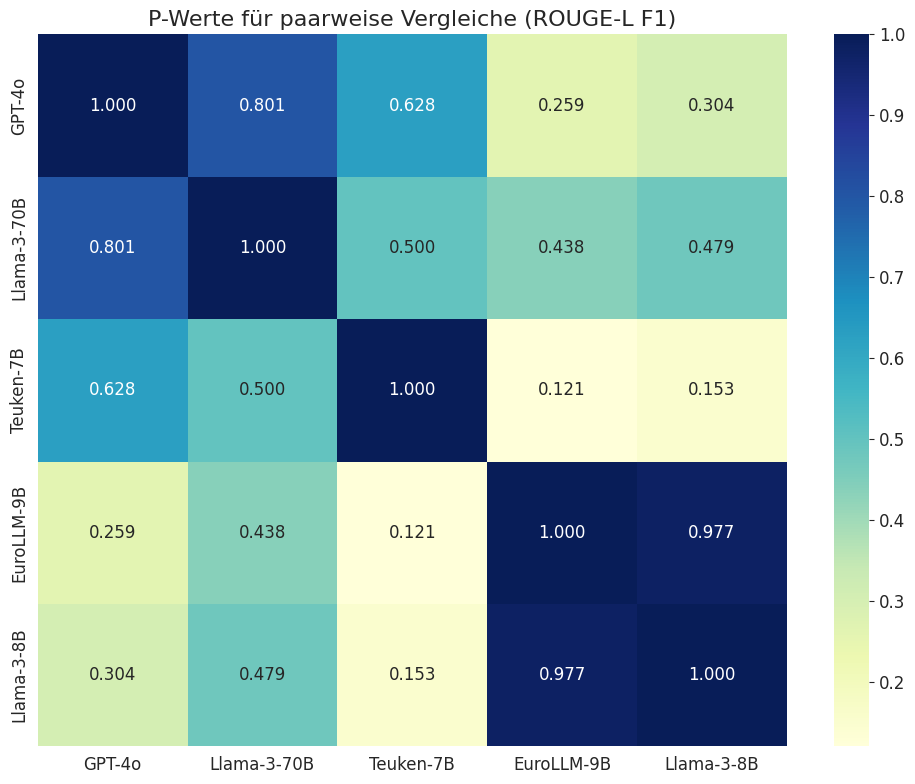


Statistische Signifikanz (p-Werte):
Werte < 0.05 deuten auf signifikante Unterschiede hin

               GPT-4o  Llama-3-70B  Teuken-7B  EuroLLM-9B  Llama-3-8B
GPT-4o       1.000000     0.801256   0.627692    0.259266    0.303993
Llama-3-70B  0.801256     1.000000   0.499548    0.438061    0.478645
Teuken-7B    0.627692     0.499548   1.000000    0.120783    0.152976
EuroLLM-9B   0.259266     0.438061   0.120783    1.000000    0.976585
Llama-3-8B   0.303993     0.478645   0.152976    0.976585    1.000000


In [81]:
# Statistische Signifikanz der Unterschiede zwischen Modellen berechnen
try:
    significance_df = compute_statistical_significance(results, metric="rougeL_fmeasure")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(significance_df, annot=True, cmap="YlGnBu", fmt=".3f")
    plt.title("P-Werte für paarweise Vergleiche (ROUGE-L F1)", fontsize=16)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "significance_heatmap.png", dpi=300)
    plt.show()
    
    print("\nStatistische Signifikanz (p-Werte):")
    print("Werte < 0.05 deuten auf signifikante Unterschiede hin\n")
    print(significance_df)
except Exception as e:
    print(f"Fehler bei der Berechnung der statistischen Signifikanz: {str(e)}")

## 7. Zusammenfassung

Hier fassen wir die wichtigsten Erkenntnisse aus der Evaluierung zusammen.

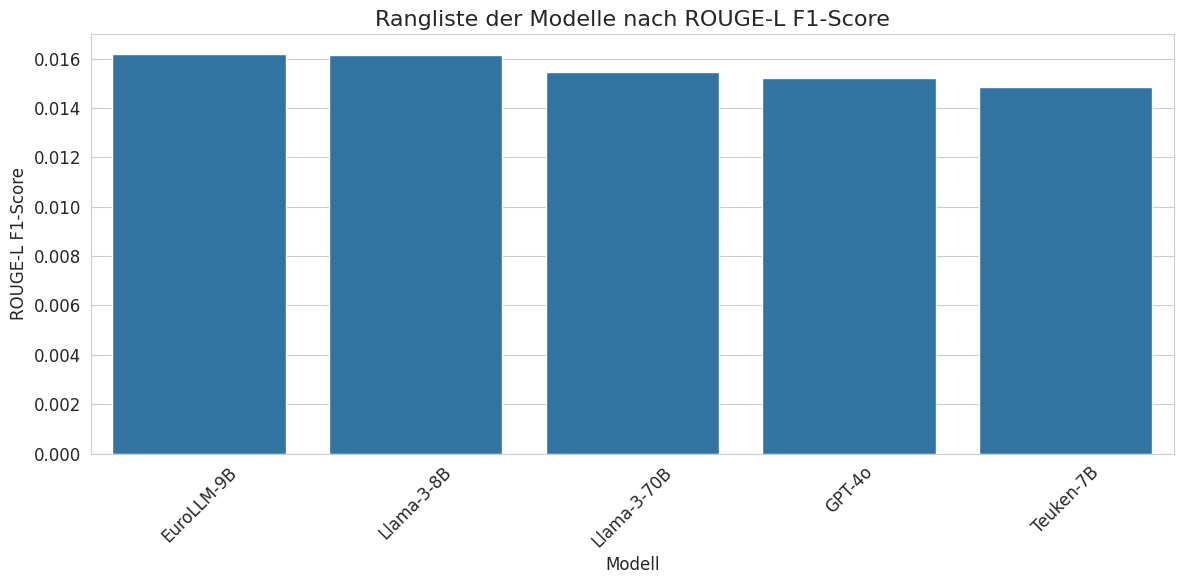


Rangliste der Modelle nach ROUGE-L F1-Score:
1. EuroLLM-9B: 0.0162
2. Llama-3-8B: 0.0161
3. Llama-3-70B: 0.0154
4. GPT-4o: 0.0152
5. Teuken-7B: 0.0148


In [82]:
# Rangliste der Modelle nach ROUGE-L F1-Score
if 'rougeL_fmeasure' in results_df.columns:
    ranked_models = results_df.sort_values(by='rougeL_fmeasure', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='model', y='rougeL_fmeasure', data=ranked_models)
    plt.title("Rangliste der Modelle nach ROUGE-L F1-Score", fontsize=16)
    plt.xlabel("Modell")
    plt.ylabel("ROUGE-L F1-Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nRangliste der Modelle nach ROUGE-L F1-Score:")
    for i, (idx, row) in enumerate(ranked_models.iterrows(), 1):
        print(f"{i}. {row['model']}: {row.get('rougeL_fmeasure', 'N/A'):.4f}")
else:
    print("\nROUGE-L F1-Score nicht in den Ergebnissen gefunden. Verwende eine andere Metrik für die Rangliste.")
    
    # Alle verfügbaren Metriken prüfen und die erste verwenden
    available_metrics = [col for col in results_df.columns if col != 'model']
    if available_metrics:
        primary_metric = available_metrics[0]
        ranked_models = results_df.sort_values(by=primary_metric, ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='model', y=primary_metric, data=ranked_models)
        plt.title(f"Rangliste der Modelle nach {primary_metric}", fontsize=16)
        plt.xlabel("Modell")
        plt.ylabel(primary_metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print(f"\nRangliste der Modelle nach {primary_metric}:")
        for i, (idx, row) in enumerate(ranked_models.iterrows(), 1):
            print(f"{i}. {row['model']}: {row.get(primary_metric, 'N/A'):.4f}")
    else:
        print("Keine Metriken für eine Rangliste gefunden.")